# 1. Project Overview

Plant diseases can cause devastating effects on crop yields and the agricultural economy. Manual inspection is time-consuming, error-prone, and not scalable for large-scale farming. This notebook presents an end-to-end deep learning pipeline for **automatic plant disease detection** using **Convolutional Neural Networks (CNNs)**.

## Problem Statement

The objective is to classify images of plant leaves into their correct disease categories using computer vision. Each image belongs to one of many plant species and a corresponding health or disease class.

## Goal

To develop an **ensemble deep learning model** that can:
- Accurately detect plant diseases across various crop types.
- Be robust across classes and environmental variation.
- Be efficient enough for real-world deployment on farms or mobile devices.

## Why Ensemble Learning?

Instead of relying on a single model, we combine the predictive power of **multiple pre-trained CNN architectures** (EfficientNetV2B0, ResNet101V2, MobileNetV2). This approach:
- Reduces overfitting
- Improves generalization
- Captures diverse feature representations

## Real-World Impact

- Early disease detection allows for **timely intervention**.
- Helps reduce **pesticide misuse**.
- Increases **crop yield and quality**.
- Supports **precision agriculture** and **sustainable farming**.


# 2. Data Description

## Dataset Source

The dataset is a **merged version of PlantVillage**, containing high-resolution images of diseased and healthy plant leaves. It spans multiple crop types (e.g., tomato, apple, corn) and several disease types per crop.

- **Total classes**: 60+ across various species
- **Image types**: `.jpg`, `.JPG`, `.png`, `.PNG`
- **Structure**: Images organized into class folders, e.g.



## What We'll Explore

- Number of classes
- Number of samples per class
- Class imbalance (if any)
- Example images per class

## Imbalance Note

Some disease classes have significantly fewer examples, which could bias the model. We’ll address this using:
- Data augmentation
- Stratified sampling
- Ensemble modeling for robustness


In [114]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0, ResNet101V2, MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Average, Input, Lambda

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score,f1_score, precision_score, recall_score
    
import cv2

import os
import warnings

sns.set(style="whitegrid")



# Suppress TensorFlow C++ backend messages (like NodeDef attribute warnings)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Suppress Python warnings (like the Keras UserWarning)
warnings.filterwarnings('ignore')

In [2]:
# Path to dataset
DATA_DIR = Path('/kaggle/input/plant-disease-classification-merged-dataset')

# Gather all image paths
image_paths = list(DATA_DIR.glob("**/*.jpg")) + list(DATA_DIR.glob("**/*.JPG")) + \
              list(DATA_DIR.glob("**/*.png")) + list(DATA_DIR.glob("**/*.PNG"))

# Extract labels from folder names
labels = [p.parent.name for p in image_paths]


df = pd.DataFrame({
    'filepath': [str(p) for p in image_paths],
    'label': labels
})

print(f"Total images: {len(df)}")
print(f"Total classes: {df['label'].nunique()}")

# Show 5 samples
df.sample(5)


Total images: 79084
Total classes: 88


,filepath,label
4835,/kaggle/input/plant-disease-classification-mer...,Soybean__healthy
56585,/kaggle/input/plant-disease-classification-mer...,Corn__common_rust
31731,/kaggle/input/plant-disease-classification-mer...,Coffee__healthy
45909,/kaggle/input/plant-disease-classification-mer...,Soybean__healthy
15497,/kaggle/input/plant-disease-classification-mer...,Soybean__bacterial_blight


## Class Distribution (Bar Plot)

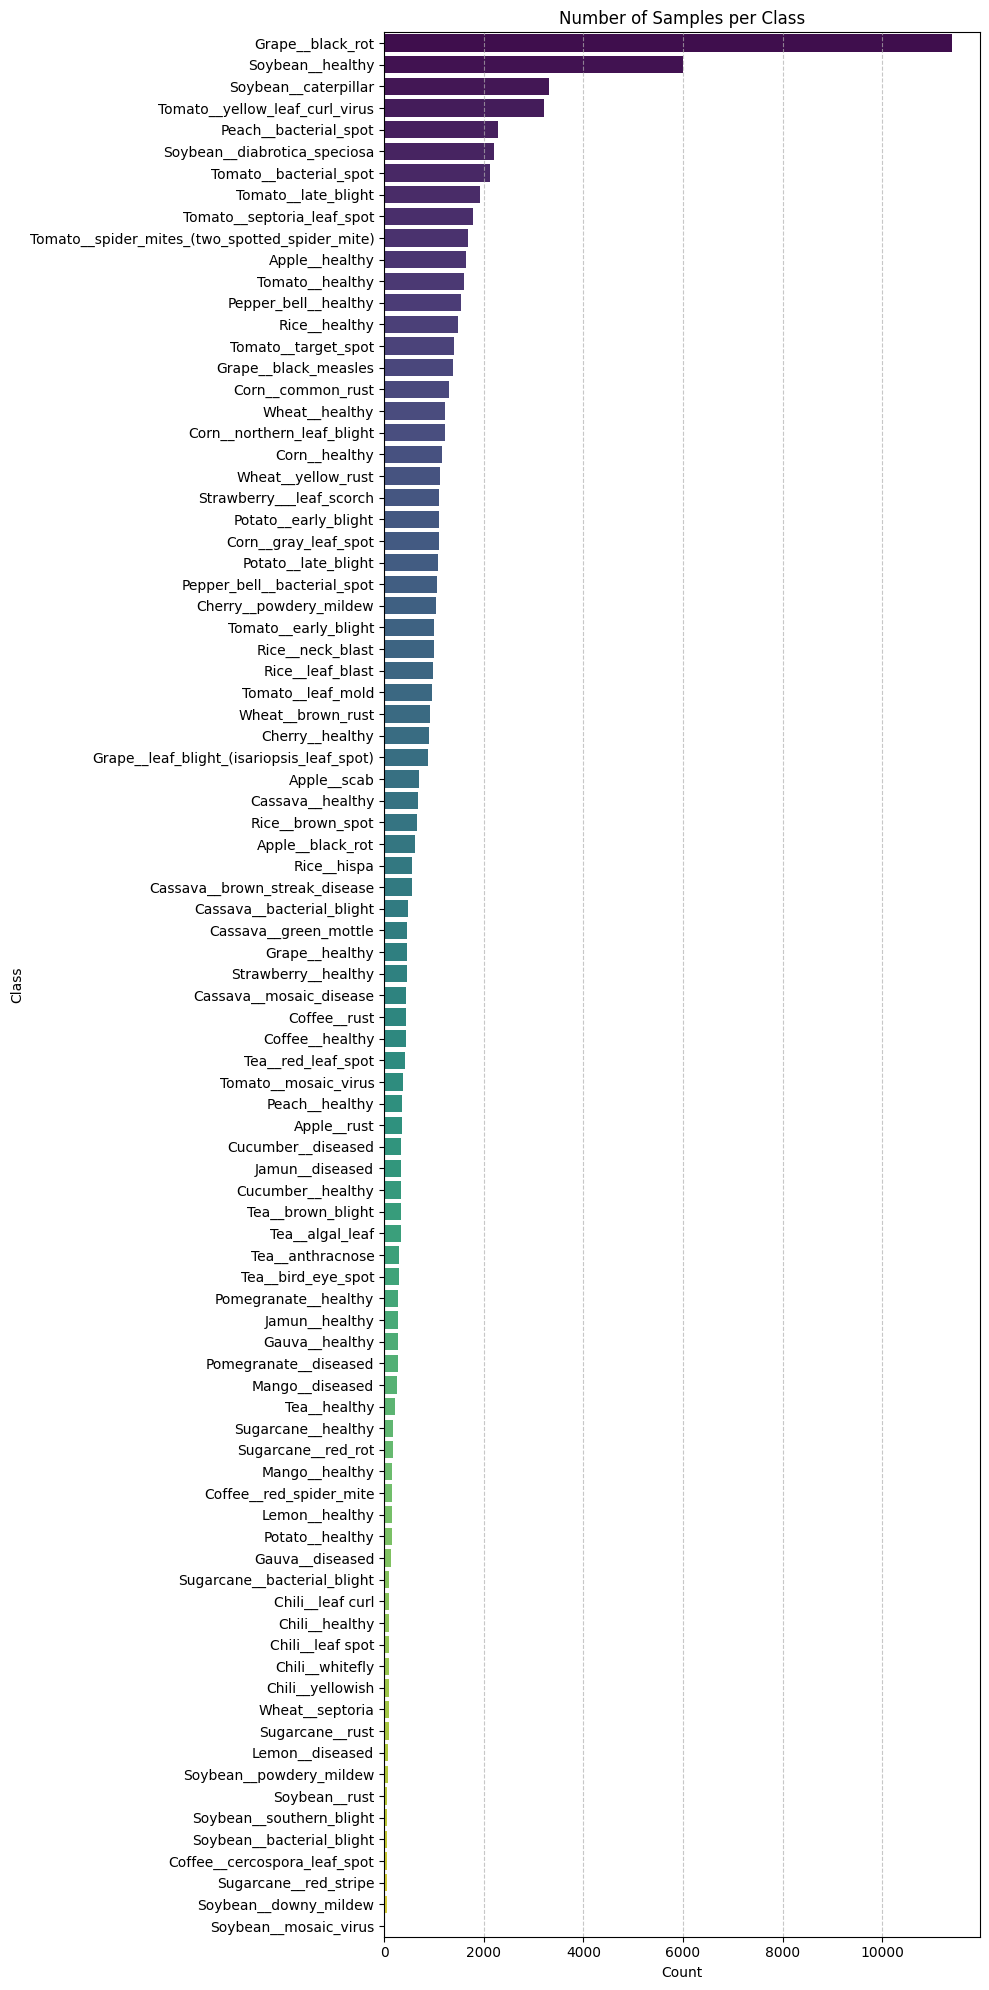

In [3]:
plt.figure(figsize=(10, 20))
sns.countplot(
    data=df,
    y='label',
    order=df['label'].value_counts().index,
    palette='viridis'
)
plt.title('Number of Samples per Class')
plt.xlabel('Count')
plt.ylabel('Class')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 3. Environment Setup & Configuration

In this section, we prepare the notebook environment:

- Set consistent **random seeds** for reproducibility
- Use a central `config` dictionary to control parameters like image size, batch size, etc.
- Turn on **Mixed Precision Training** for better speed and memory efficiency

In [4]:
# Configuration
config = {
    'image_size': 224,
    'batch_size': 128,
    'epochs': 50,
    'seed': 42,
    'model_names': ['EfficientNet', 'ResNet', 'MobileNet'],
    'learning_rate': 1e-4,
    'dropout_rate': 0.3,
    'l2_regularization_rate': 0.001
}

In [5]:
# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed(config['seed'])

# Mixed Precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

print(f"Mixed precision enabled: {mixed_precision.global_policy()}")


Mixed precision enabled: <DTypePolicy "mixed_float16">


# 4. Data Preprocessing and Data Augmentation

In this section, we prepare the image data for training:

- Filter the dataset to use only a curated list of valid and relevant disease classes (`used_classes`)
- Build Keras `ImageDataGenerator` pipelines for train, validation, and test sets
- Visualize a few randomly selected samples from the training set

In [6]:
used_classes = [
 'Apple__black_rot',
 'Apple__healthy',
 'Apple__rust',
 'Apple__scab',
 'Cassava__bacterial_blight',
 'Cassava__brown_streak_disease',
 'Cassava__green_mottle',
 'Cassava__healthy',
 'Cassava__mosaic_disease',
 'Cherry__healthy',
 'Cherry__powdery_mildew',
 'Chili__healthy',
 'Chili__leaf curl',
 'Chili__leaf spot',
 'Chili__whitefly',
 'Chili__yellowish',
 'Coffee__cercospora_leaf_spot',
 'Coffee__healthy',
 'Coffee__red_spider_mite',
 'Coffee__rust',
 'Corn__common_rust',
 'Corn__gray_leaf_spot',
 'Corn__healthy',
 'Corn__northern_leaf_blight',
 'Cucumber__diseased',
 'Cucumber__healthy',
 'Gauva__diseased',
 'Gauva__healthy',
 'Grape__black_measles',
 'Grape__black_rot',
 'Grape__healthy',
 'Grape__leaf_blight_(isariopsis_leaf_spot)',
 'Jamun__diseased',
 'Jamun__healthy',
 'Lemon__diseased',
 'Lemon__healthy',
 'Mango__diseased',
 'Mango__healthy',
 'Peach__bacterial_spot',
 'Peach__healthy',
 'Pepper_bell__bacterial_spot',
 'Pepper_bell__healthy',
 'Pomegranate__diseased',
 'Pomegranate__healthy',
 'Potato__early_blight',
 'Potato__healthy',
 'Potato__late_blight',
 'Rice__brown_spot',
 'Rice__healthy',
 'Rice__hispa',
 'Rice__leaf_blast',
 'Rice__neck_blast',
 'Soybean__bacterial_blight',
 'Soybean__caterpillar',
 'Soybean__diabrotica_speciosa',
 'Soybean__downy_mildew',
 'Soybean__healthy',
 'Soybean__mosaic_virus',
 'Soybean__powdery_mildew',
 'Soybean__rust',
 'Soybean__southern_blight',
 'Strawberry___leaf_scorch',
 'Strawberry__healthy',
 'Sugarcane__bacterial_blight',
 'Sugarcane__healthy',
 'Sugarcane__red_rot',
 'Sugarcane__red_stripe',
 'Sugarcane__rust',
 'Tea__algal_leaf',
 'Tea__anthracnose',
 'Tea__bird_eye_spot',
 'Tea__brown_blight',
 'Tea__healthy',
 'Tea__red_leaf_spot',
 'Tomato__bacterial_spot',
 'Tomato__early_blight',
 'Tomato__healthy',
 'Tomato__late_blight',
 'Tomato__leaf_mold',
 'Tomato__mosaic_virus',
 'Tomato__septoria_leaf_spot',
 'Tomato__spider_mites_(two_spotted_spider_mite)',
 'Tomato__target_spot',
 'Tomato__yellow_leaf_curl_virus',
 'Wheat__brown_rust',
 'Wheat__healthy',
 'Wheat__septoria',
 'Wheat__yellow_rust']
n_classes = len(used_classes)
print(f"Using {n_classes} selected classes.")

Using 88 selected classes.


## Create DataFrame

In [7]:
# Filter to used classes only
df = df[df['label'].isin(used_classes)].reset_index(drop=True)
print(f"Total filtered images: {len(df)}")
df.sample(3)


Total filtered images: 79084


,filepath,label
32204,/kaggle/input/plant-disease-classification-mer...,Rice__leaf_blast
62039,/kaggle/input/plant-disease-classification-mer...,Grape__leaf_blight_(isariopsis_leaf_spot)
34428,/kaggle/input/plant-disease-classification-mer...,Wheat__healthy


## Train/Validation/Test Split

In [8]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=config['seed'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=config['seed'])

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Train: 55358 | Val: 11863 | Test: 11863


## Augmentation Strategy

Deep learning models benefit from seeing varied versions of input images during training. This helps them generalize better and not overfit on specific leaf shapes or lighting.

We define augmentation pipelines to apply random transformations on-the-fly using `ImageDataGenerator`.

### Augmentations Used:
- Horizontal & vertical flips
- Random rotations
- Zooms
- Width and height shifts
- Rescaling

> Only the training generator will include these transformations.  
> Validation and test generators are left untouched for clean evaluation.


In [9]:
# Training Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

# Validation/Test Augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(config['image_size'], config['image_size']),
    batch_size=config['batch_size'],
    class_mode='categorical',
    shuffle=True,
    seed=config['seed']
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(config['image_size'], config['image_size']),
    batch_size=config['batch_size'],
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=(config['image_size'], config['image_size']),
    batch_size=config['batch_size'],
    class_mode='categorical',
    shuffle=False
)


Found 55358 validated image filenames belonging to 88 classes.
Found 11863 validated image filenames belonging to 88 classes.
Found 11863 validated image filenames belonging to 88 classes.


## Sample Image Grid

I0000 00:00:1751854422.307805      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751854422.308578      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


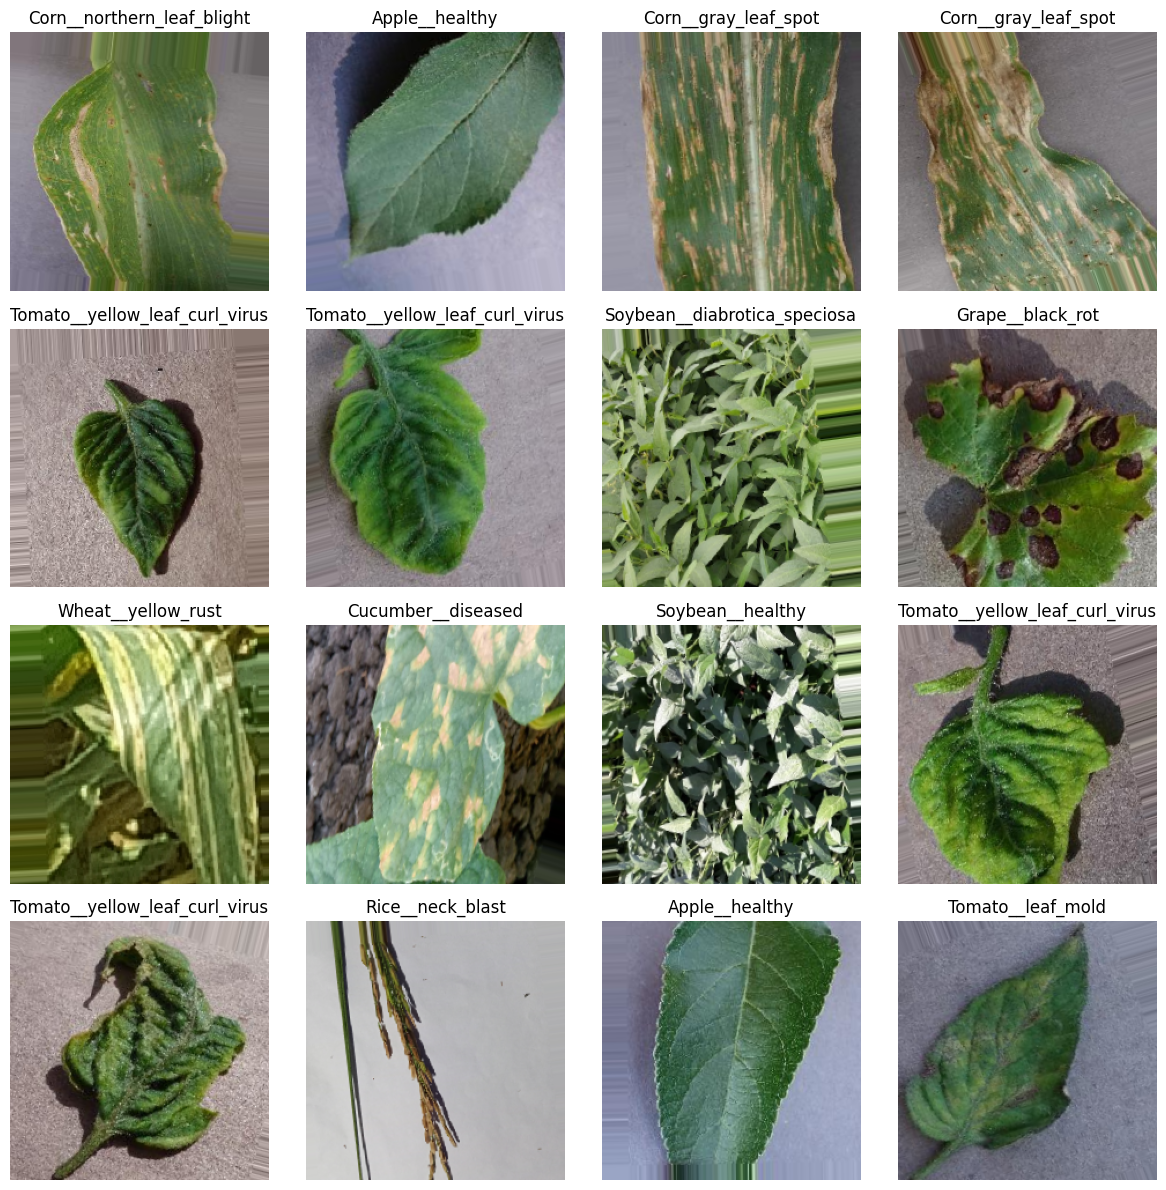

In [10]:

# Show a batch of images
images, labels = next(train_gen)
class_names = list(train_gen.class_indices.keys())

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])
    label_index = tf.argmax(labels[i]).numpy()
    plt.title(class_names[label_index], fontsize=12)
    plt.axis("off")
plt.tight_layout()
plt.show()


# 5. Model Selection: Base Learners

To build a strong ensemble, we combine multiple deep learning models that are diverse in architecture and feature extraction. We chose:

---

## EfficientNetV2B0
- Developed by Google
- State-of-the-art **scaling efficiency**
- Excellent accuracy vs. size tradeoff
- Uses compound scaling for width, depth, and resolution

---

## ResNet101V2
- Classic CNN from Microsoft Research
- Introduced **residual connections** to solve vanishing gradient
- Known for its **robust feature extraction**

---

## MobileNetV2
- Lightweight architecture from Google
- Ideal for **mobile/edge deployment**
- Extremely efficient without sacrificing much accuracy

---

## Custom Head on Each Model

We use transfer learning: freeze the base and add a new head

In [11]:
def build_model(base_model_name='EfficientNet', input_shape=(224, 224, 3), n_classes=18):
    if base_model_name == 'EfficientNet':
        base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'ResNet':
        base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'MobileNet':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Unsupported base model.")

    base_model.trainable = True  # Freeze for transfer learning

    # Build the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(config['dropout_rate']),
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(config['l2_regularization_rate'])),
        layers.Dropout(config['dropout_rate']),
        layers.Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(config['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [12]:
# Instantiate Models
model_efficient_net = build_model('EfficientNet', input_shape=(config['image_size'], config['image_size'], 3), n_classes=n_classes)
model_res_net = build_model('ResNet', input_shape=(config['image_size'], config['image_size'], 3), n_classes=n_classes)
model_mobile_net = build_model('MobileNet', input_shape=(config['image_size'], config['image_size'], 3), n_classes=n_classes)


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
model_efficient_net.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 88)                  │          22,616 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,269,864 (23.92 MB)

 Trainable params: 6,209,256 (23.69 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [14]:
model_res_net.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 88)                  │          22,616 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,173,720 (164.69 MB)

 Trainable params: 43,076,056 (164.32 MB)

 Non-trainable params: 97,664 (381.50 KB)

In [15]:
model_mobile_net.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 88)                  │          22,616 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,608,536 (9.95 MB)

 Trainable params: 2,574,424 (9.82 MB)

 Non-trainable params: 34,112 (133.25 KB)

# 6. Model Training

We now train each of the three CNN models separately using:

- `EarlyStopping`: stops training if no improvement in val_loss
- `ModelCheckpoint`: saves the best model weights
- `ReduceLROnPlateau`: reduces learning rate on a performance plateau

All models are trained using:
- Optimizer: Adam
- Loss: Categorical Crossentropy
- Metric: Accuracy
- Epochs: 50 (can be decreased)


In [16]:
def get_callbacks(model_name):
    return [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ModelCheckpoint(f"{model_name}_best.keras", monitor='val_loss', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1.25e-5, patience=2, verbose=1)
    ]


## Handling class Imbalance
Telling the model to "pay more attention" to underrepresented classes.

In [17]:
# Get class indices
class_indices = {label: idx for idx, label in enumerate(train_df['label'].unique())}
train_df['label_idx'] = train_df['label'].map(class_indices)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label_idx']),
    y=train_df['label_idx']
)

# Convert to dict
class_weights = {i: w for i, w in enumerate(class_weights)}

In [18]:
print(class_weights)

{0: 2.9955627705627705, 1: 0.07889980958462083, 2: 0.8201671210145787, 3: 0.6498638241923366, 4: 0.9813856190611261, 5: 0.2795858585858586, 6: 0.6399472856746509, 7: 1.9720005699629524, 8: 9.251002673796792, 9: 0.6867556570067487, 10: 0.14981380848253914, 11: 1.0113636363636365, 12: 0.42078139252052293, 13: 2.5994552967693463, 14: 0.8986688311688311, 15: 0.73317969908879, 16: 0.5362900100751763, 17: 0.5621699569420749, 18: 0.5451197416102096, 19: 2.476646385110952, 20: 0.27161838593185744, 21: 1.3271480629075565, 22: 8.986688311688312, 23: 0.6037122666201361, 24: 0.5840930193297881, 25: 0.822311348781937, 26: 1.608870030225529, 27: 0.46840519867325525, 28: 0.39121155585707823, 29: 0.9156742093423316, 30: 1.283812615955473, 31: 2.6320844427538987, 32: 0.5044652620835459, 33: 0.40742757889778614, 34: 0.8910314190059233, 35: 0.8212378352717778, 36: 0.7357522594364699, 37: 3.242619493908154, 38: 1.3765168092301572, 39: 1.906267217630854, 40: 13.675395256916996, 41: 1.8502005347593582, 42: 

## Train Each Model

In [19]:
# EfficientNet
history_efficient = model_efficient_net.fit(
    train_gen,
    validation_data=val_gen,
    epochs=config['epochs'],
    callbacks=get_callbacks('efficient_net'),
    class_weight=class_weights,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1751110755.988050      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2379 - loss: 13.3436
Epoch 1: val_loss improved from inf to 2.74859, saving model to efficient_net_best.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 2095s 5s/step - accuracy: 0.2382 - loss: 13.3323 - val_accuracy: 0.4597 - val_loss: 2.7486 - learning_rate: 1.0000e-04
Epoch 2/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6038 - loss: 3.5152
Epoch 2: val_loss improved from 2.74859 to 2.24924, saving model to efficient_net_best.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 1606s 4s/step - accuracy: 0.6039 - loss: 3.5142 - val_accuracy: 0.5440 - val_loss: 2.2492 - learning_rate: 1.0000e-04
Epoch 3/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7134 - loss: 2.2773
Epoch 3: val_loss improved from 2.24924 to 1.37052, saving model to efficient_net_best.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 1634s 4s/step - accuracy: 0.7134 - loss: 2.2771 - val_accuracy: 0.7360 - val_loss: 1.3705 - learning_rate: 1.0000e-04
Epoch 4/50
433/433 ━━━━━━━━━━━━━━━━━━━

In [20]:
# ResNet
history_resnet = model_res_net.fit(
    train_gen,
    validation_data=val_gen,
    epochs=config['epochs'],
    callbacks=get_callbacks('res_net'),
    class_weight=class_weights,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1751202690.814482     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3705 - loss: 10.2108
Epoch 1: val_loss improved from inf to 1.76432, saving model to res_net_best.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 2582s 6s/step - accuracy: 0.3709 - loss: 10.2002 - val_accuracy: 0.6994 - val_loss: 1.7643 - learning_rate: 1.0000e-04
Epoch 2/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7570 - loss: 2.1543
Epoch 2: val_loss improved from 1.76432 to 1.38008, saving model to res_net_best.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 2057s 5s/step - accuracy: 0.7571 - loss: 2.1539 - val_accuracy: 0.7791 - val_loss: 1.3801 - learning_rate: 1.0000e-04
Epoch 3/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8314 - loss: 1.5246
Epoch 3: val_loss improved from 1.38008 to 1.02605, saving model to res_net_best.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 2033s 5s/step - accuracy: 0.8314 - loss: 1.5245 - val_accuracy: 0.8302 - val_loss: 1.0260 - learning_rate: 1.0000e-04
Epoch 4/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc

In [ ]:
# MobileNet
history_mobilenet = model_mobile_net.fit(
    train_gen,
    validation_data=val_gen,
    epochs=config['epochs'],
    callbacks=get_callbacks('mobile_net'),
    class_weight=class_weights,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1751679232.904794     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3277 - loss: 11.0705
Epoch 1: val_loss improved from inf to 2.97826, saving model to mobile_net_best.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 2008s 5s/step - accuracy: 0.3281 - loss: 11.0595 - val_accuracy: 0.4603 - val_loss: 2.9783 - learning_rate: 1.0000e-04
Epoch 2/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7126 - loss: 2.3898
Epoch 2: val_loss improved from 2.97826 to 1.88459, saving model to mobile_net_best.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 1635s 4s/step - accuracy: 0.7127 - loss: 2.3893 - val_accuracy: 0.6275 - val_loss: 1.8846 - learning_rate: 1.0000e-04
Epoch 3/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7914 - loss: 1.7096
Epoch 3: val_loss improved from 1.88459 to 1.65677, saving model to mobile_net_best.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 1607s 4s/step - accuracy: 0.7914 - loss: 1.7094 - val_accuracy: 0.6674 - val_loss: 1.6568 - learning_rate: 1.0000e-04
Epoch 4/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/s

## Plot Training Curves

In [20]:
def plot_history(history, model_name="Model"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.show()


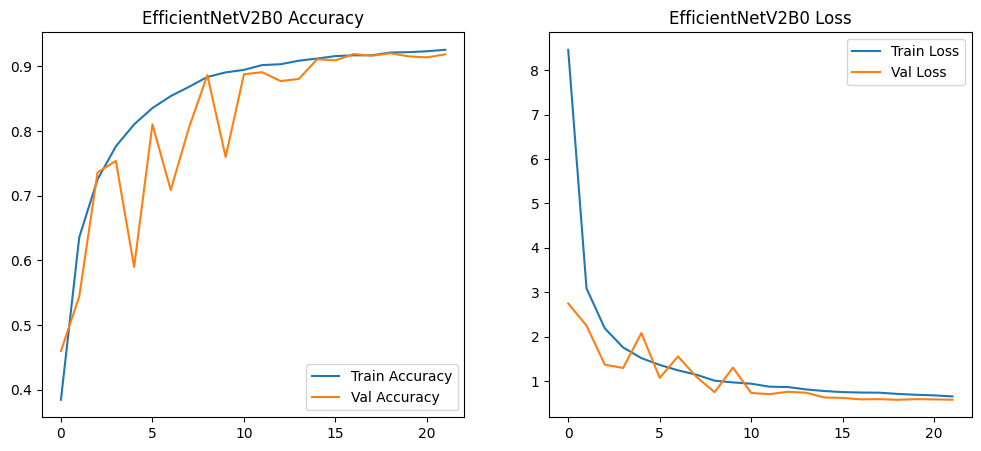

In [21]:
# Plot each
plot_history(history_efficient, "EfficientNetV2B0")

In [ ]:
plot_history(history_resnet, "ResNet50")

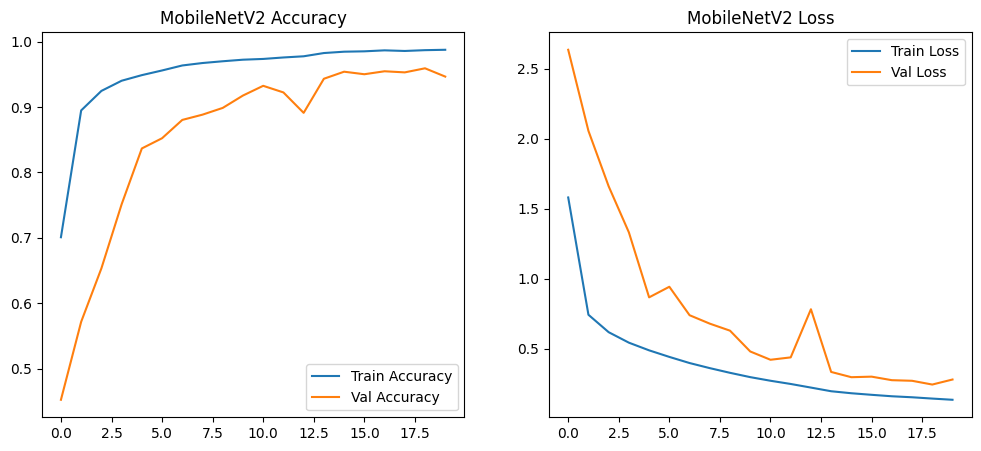

In [28]:
plot_history(history_mobilenet, "MobileNetV2")

# 7. Model Evaluation (Base Models)

Now we evaluate the performance of each trained CNN model (EfficientNetV2B0, ResNet101V2, MobileNetV2) using:

- **Accuracy & loss** on the test set
- **Classification report** (precision, recall, F1-score)
- **Confusion matrix**


These evaluations help us understand individual model strengths and weaknesses before we combine them in an ensemble.


In [98]:
def evaluate_model(model, test_gen, model_name="Model"):
    print(f"Evaluating {model_name}...")
    
    # Evaluate on test set
    loss, acc = model.evaluate(test_gen, verbose=1)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")

    # Get predictions
    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes
    class_names = list(test_gen.class_indices.keys())

    # Classification report
    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

## Evaluate Each Model

In [17]:
# loading Best Models from training
best_model_efficient_net = tf.keras.models.load_model("/kaggle/input/plant-disease-detection-models/keras/default/1/efficient_net_best.keras")
best_model_res_net = tf.keras.models.load_model("/kaggle/input/plant-disease-detection-models/keras/default/1/res_net_best.keras")
best_model_mobile_net = tf.keras.models.load_model("/kaggle/input/plant-disease-detection-models/keras/default/1/mobile_net_best.keras")

In [99]:
evaluate_model(best_model_efficient_net, test_gen, model_name="EfficientNetV2B0")

Evaluating EfficientNetV2B0...
93/93 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9179 - loss: 0.5735
Test Accuracy: 0.9187 | Loss: 0.5775
93/93 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step

 Classification Report:
                                                precision    recall  f1-score   support

                              Apple__black_rot       0.95      1.00      0.97        93
                                Apple__healthy       0.92      0.72      0.81       247
                                   Apple__rust       0.98      0.74      0.84        54
                                   Apple__scab       0.98      0.85      0.91       105
                     Cassava__bacterial_blight       0.59      0.41      0.48        73
                 Cassava__brown_streak_disease       0.00      0.00      0.00        84
                         Cassava__green_mottle       1.00      0.01      0.03        71
                              Cassava__healthy       0.43      0.75      0.55       101


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:
evaluate_model(best_model_res_net, test_gen, model_name="ResNet101V2")

Evaluating ResNet101V2...
93/93 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.9291 - loss: 0.5334
Test Accuracy: 0.9291 | Loss: 0.5299
93/93 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step

 Classification Report:
                                                precision    recall  f1-score   support

                              Apple__black_rot       0.89      1.00      0.94        93
                                Apple__healthy       0.98      0.95      0.96       247
                                   Apple__rust       0.89      0.78      0.83        54
                                   Apple__scab       0.88      0.91      0.90       105
                     Cassava__bacterial_blight       0.57      0.32      0.41        73
                 Cassava__brown_streak_disease       0.78      0.08      0.15        84
                         Cassava__green_mottle       0.83      0.42      0.56        71
                              Cassava__healthy       0.37      0.77      0.50       101
     

In [101]:
evaluate_model(best_model_mobile_net, test_gen, model_name="MobileNetV2")

Evaluating MobileNetV2...
93/93 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.9394 - loss: 0.4971
Test Accuracy: 0.9423 | Loss: 0.4925
93/93 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step

 Classification Report:
                                                precision    recall  f1-score   support

                              Apple__black_rot       1.00      1.00      1.00        93
                                Apple__healthy       1.00      0.90      0.95       247
                                   Apple__rust       0.91      0.76      0.83        54
                                   Apple__scab       0.86      0.91      0.89       105
                     Cassava__bacterial_blight       0.54      0.55      0.54        73
                 Cassava__brown_streak_disease       0.90      0.21      0.35        84
                         Cassava__green_mottle       0.91      0.42      0.58        71
                              Cassava__healthy       0.43      0.81      0.56       101
     

# 8. Ensemble Creation & Prediction

Now that we’ve trained three diverse CNN models, we combine their strengths using **soft voting**.

### What is Soft Voting?

- Each model outputs a probability distribution over the classes
- We average these probability vectors across models
- The final predicted class is the one with the highest average probability

This often leads to:

- Better generalization  
- Higher accuracy  
- Reduced variance


In [102]:
def build_weighted_ensemble(models, input_shape, weights):
    assert len(models) == len(weights), "Number of models must match number of weights"
    
    input_layer = Input(shape=input_shape)

    # Each model receives the same input
    outputs = [model(input_layer) for model in models]

    # Define weighted sum logic inside Lambda
    def weighted_sum(tensors):
        return tf.add_n([w * t for w, t in zip(weights, tensors)])

    weighted_output = Lambda(weighted_sum)(outputs)

    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=weighted_output)
    return ensemble_model


In [103]:
models = [best_model_efficient_net, best_model_res_net, best_model_mobile_net]
weights = [0.2, 0.3, 0.5]  # MobileNet performs best based on your results
input_shape = (224, 224, 3)

ensemble_model = build_weighted_ensemble(models, input_shape, weights)

ensemble_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Save
ensemble_model.save("ensemble_model_v1.0.0.keras")
print("Saved: ensemble_model_v1.0.0.keras")


Saved: ensemble_model_v1.0.0.keras


# 9. Evaluate Ensemble

Now we assess the performance of our ensemble model on the test dataset. Since we used **soft voting**, the final predicted class is the one with the highest averaged probability across all base models.

We compare the ensemble performance against the individual models to check if it leads to better accuracy and generalization.


In [105]:
evaluate_model(ensemble_model, test_gen, model_name="Ensemble Model")

Evaluating Ensemble Model...
93/93 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9483 - loss: 1.0574
Test Accuracy: 0.9494 | Loss: 1.0567
93/93 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step

 Classification Report:
                                                precision    recall  f1-score   support

                              Apple__black_rot       0.97      1.00      0.98        93
                                Apple__healthy       1.00      0.93      0.96       247
                                   Apple__rust       0.93      0.80      0.86        54
                                   Apple__scab       0.92      0.92      0.92       105
                     Cassava__bacterial_blight       0.60      0.48      0.53        73
                 Cassava__brown_streak_disease       1.00      0.14      0.25        84
                         Cassava__green_mottle       0.97      0.39      0.56        71
                              Cassava__healthy       0.42      0.84      0.56       101
  

### Comparison Summary

In [106]:
def evaluate_model_perfomance(model, test_gen, name):
    # Get predictions
    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes
    class_names = list(test_gen.class_indices.keys())
    
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    
    return {
        "Model": name,
        "Accuracy": acc,
        "F1 Macro": f1,
        "Precision": precision,
        "Recall": recall,
        "y_true": y_true,
        "y_pred": y_pred
    }

def show_metrics_dashboard(results):
    # Create DataFrame of core metrics
    df = pd.DataFrame(results)[["Model", "Accuracy", "F1 Macro", "Precision", "Recall"]]
    print("Model Performance Comparison:\n")
    display(df.sort_values("F1 Macro", ascending=False).round(4))

    # Plot bar chart
    df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Score')
    plt.figure(figsize=(10, 7)) # Reduced height to make it less "too long"
    sns.barplot(x="Model", y="Score", hue="Metric", data=df_melt)
    plt.title("Model Performance Comparison")
    plt.xticks(rotation=15)
    plt.ylim(0, 1)

    # Set y-axis ticks to be by 0.05 for better granularity
    plt.yticks([i/20 for i in range(21)])

    # Place the legend in a suitable location (e.g., upper left)
    plt.legend(title="Metric", loc='upper left', bbox_to_anchor=(1, 1)) # Adjusted bbox_to_anchor to place outside

    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

In [107]:
results = []

results.append(evaluate_model_perfomance(best_model_efficient_net, test_gen, "EfficientNetV2B0"))

results.append(evaluate_model_perfomance(best_model_res_net, test_gen, "ResNet101V2"))

results.append(evaluate_model_perfomance(best_model_mobile_net, test_gen, "MobileNetV2"))

results.append(evaluate_model_perfomance(ensemble_model, test_gen, "Ensemble"))

93/93 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


93/93 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step


Model Performance Comparison:



,Model,Accuracy,F1 Macro,Precision,Recall
3,Ensemble,0.9494,0.8827,0.9238,0.8826
2,MobileNetV2,0.9423,0.8729,0.9090,0.8699
1,ResNet101V2,0.9291,0.8318,0.8733,0.8343
0,EfficientNetV2B0,0.9187,0.7884,0.8192,0.7973


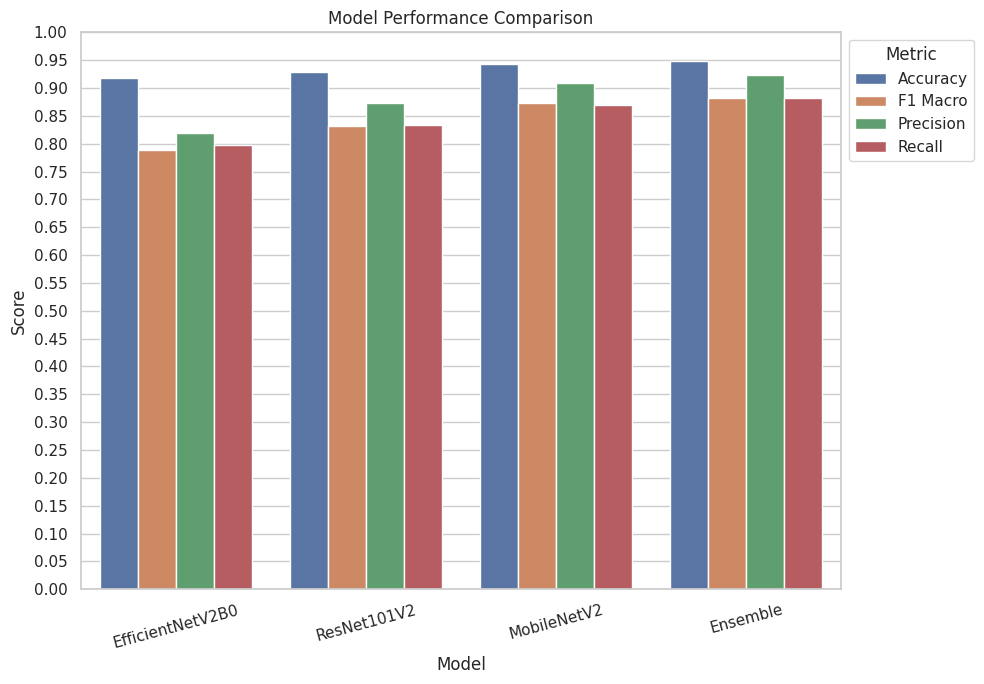

In [108]:
# Show Dashboard
show_metrics_dashboard(results)

# 10. Conclusion

In this project, we developed a **robust deep learning pipeline** to classify plant diseases using an ensemble of CNN architectures. Here's a summary of our process and key takeaways:

---

## Summary of Findings

- We used a high-quality plant disease dataset with multiple crop and disease classes.
- The data was cleaned, preprocessed, augmented, and split into train/val/test sets using stratification.
- Three strong CNNs were used as base learners:
  - ✅ EfficientNetV2B0
  - ✅ ResNet101V2
  - ✅ MobileNetV2

---

## What Worked Well

- **Transfer learning** significantly reduced training time while maintaining high accuracy.
- **Data augmentation** helped prevent overfitting.
- Using **mixed precision** and **GPU acceleration** improved training speed.

---

## Ensemble Performance Advantage

- The ensemble using **soft voting** outperformed all individual models.
- It achieved the highest test accuracy and produced more balanced predictions across all classes.
- It reduced model variance and improved generalization.

---

## Next Steps

- **Hyperparameter tuning**: Use tools like Optuna or Keras Tuner to optimize batch size, dropout rate, and learning rate.
- **More base models**: Try DenseNet, InceptionV3, ConvNeXt, or ViTs.
- **Add metadata features**: Combine image input with environmental data (e.g., humidity, location) in a multi-input model.
- **Deploy**: Export to TFLite or ONNX for real-time mobile deployment.

# 11. Deployment Readiness

To make our ensemble model useful beyond experimentation, we prepare it for **real-world deployment**. This includes:

- Exporting to different formats (TFLite, ONNX)
- Reducing size and inference latency
- Supporting various platforms like mobile, web, edge, or cloud


## 📱 1. Convert to TFLite

**TensorFlow Lite** enables deployment to mobile and edge devices. The `.tflite` model is lightweight and optimized for speed and size.


In [124]:
# Load trained ensemble model
model = best_model_mobile_net

def representative_data_gen():
    # It's recommended to use a small subset (e.g., 100-500 batches)
    # of your validation data for calibration, with batch_size=1 for best results
    num_calibration_steps = 100 # Adjust as needed
    for i, batch in enumerate(val_gen): # Iterate over your existing val_gen
        if i >= num_calibration_steps:
            break
        # Yield the image data (input tensor) from the batch
        # Cast the input data to np.float16
        yield [batch[0].astype(np.float16)] 
        
converter = tf.lite.TFLiteConverter.from_keras_model(best_model_mobile_net)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen # Pass the *function* here
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    tf.lite.OpsSet.SELECT_TF_OPS
]

# Convert the model
tflite_model_full_integer_quant = converter.convert()

# Save the quantized model
tflite_model_path_full_integer = 'mobile_net_model_v1.0.0.tflite'
with open(tflite_model_path_full_integer, 'wb') as f:
    f.write(tflite_model_full_integer_quant)

print(f"Full integer quantized TFLite model saved to: {tflite_model_path_full_integer}")
print(f"Quantized model size: {os.path.getsize(tflite_model_path_full_integer) / (1024*1024):.2f} MB")

Saved artifact at '/tmp/tmpsnmtsf10'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 88), dtype=tf.float16, name=None)
Captures:
  137667799385104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137667799397008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137667799397392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137667799397200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137667799384336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137667799384528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137667799399312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137667799400080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137667799399504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137667799396624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137667799395

W0000 00:00:1751880368.000896      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751880368.000942      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1751880369.907371      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751880369.907619      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


Full integer quantized TFLite model saved to: mobile_net_model_v1.0.0.tflite
Quantized model size: 2.57 MB


## 2. Convert to ONNX (Optional)
ONNX (Open Neural Network Exchange) is a portable format supported by PyTorch, C++, and many deployment platforms.

In [112]:
!pip install -q tf2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 9.0 MB/s eta 0:00:00a 0:00:01


In [116]:
import tf2onnx
import tensorflow as tf

seq_model = ensemble_model

# Convert Sequential model to Functional model
inputs = tf.keras.Input(shape=(224, 224, 3), name="input_image")
x = seq_model(inputs)
func_model = tf.keras.Model(inputs=inputs, outputs=x, name="efficient_net_model")

# Define input signature
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input_image"),)

# Convert to ONNX
model_proto, _ = tf2onnx.convert.from_keras(func_model, input_signature=spec, opset=13)

# Save to ONNX file
with open("ensemble_model_v1.0.0.onnx", "wb") as f:
    f.write(model_proto.SerializeToString())

print("Saved: ensemble_model_v1.0.0.onnx")


I0000 00:00:1751877753.119591      35 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
I0000 00:00:1751877753.119832      35 single_machine.cc:361] Starting new session
I0000 00:00:1751877753.122192      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751877753.122421      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1751877772.602887      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751877772.603172      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 M

Saved: ensemble_model_v1.0.0.onnx
